In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       

In [2]:
catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'

combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print (list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd']


In [49]:
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 6
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask()
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords)

# native stores are available at zoom 10 ~6.4km and lower, fewer variables and all are 2d
zoom_select_dsn = 8
dsn = combo_cat.xsh24_native(zoom=zoom_select_dsn).to_dask()
dsn = dsn.pipe(egh.attach_coords)

# we downloaded output from DOE's SCREAM model to stellar
# conceivably, we could add to our local collection of models during the week
# or augment the catalog with observational datasets
ds_scream = combo_cat.scream_ne120(zoom=zoom_select).to_dask()
ds_scream = ds_scream.pipe(egh.attach_coords)

/home/rv5936/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/rv5936/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/rv5936/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping 

In [50]:
def worldmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    # ax.add_feature(cf.COASTLINE, linewidth=0.8)
    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)


In [51]:
daily_cape_max = dsn['CAPE_max'].sel(time=slice('2020-01-01','2020-12-31')).groupby('time.dayofyear').max('time')

<h4>Limited-Area healpix</h4>

Following: https://easy.gems.dkrz.de/Processing/healpix/limited_area_healpix.html

In [52]:
def get_axis_la(extent, subplot_kw=None):
    """Create cartopy.GeoAxis limited area with for a given extent."""
    if not subplot_kw:
        subplot_kw = {"projection": ccrs.PlateCarree()}
        
    fig, ax = plt.subplots(subplot_kw=subplot_kw)
    # ax.coastlines()
    ax.set_extent(extent)
    
    return fig, ax

In [53]:
north_america = [-110, -60, 15, 65]
se_australia  = [140, 170, -50, -20]
arabian_sea   = []

In [54]:
order = zoom_select_dsn
nside = hp.order2nside(order)
npix = hp.nside2npix(nside)

hp_lon, hp_lat = hp.pix2ang(nside, np.arange(npix), nest=True, lonlat=True)
hp_lon = (hp_lon + 180) % 360 - 180

# Find all grid points within the defined extent
na_cells, = np.where(
    (hp_lon > north_america[0]) &
    (hp_lon < north_america[1]) &
    (hp_lat > north_america[2]) &
    (hp_lat < north_america[3]))

au_cells, = np.where(
    (hp_lon > se_australia[0]) &
    (hp_lon < se_australia[1]) &
    (hp_lat > se_australia[2]) &
    (hp_lat < se_australia[3]))

# as_cells, = np.where(
#     (hp_lon > arabian_sea[0]) &
#     (hp_lon < arabian_sea[1]) &
#     (hp_lat > arabian_sea[2]) &
#     (hp_lat < arabian_sea[3]))

In [55]:
na_filter = lambda da: da.isel(cell=na_cells)
au_filter = lambda da: da.isel(cell=au_cells)

In [56]:
na_cape = na_filter(daily_cape_max).compute()
au_cape = au_filter(daily_cape_max).compute()

In [57]:
get_quantile = lambda da, q: xr.apply_ufunc(lambda da, q: np.quantile(da, q, axis=1), da, q,
                                            input_core_dims =[['cell', 'dayofyear'], []], 
                                            output_core_dims=[['cell']])

In [59]:
# %%time
na_filter(daily_cape_max).compute()

<xarray.DataArray 'CAPE_max' (dayofyear: 366, cell: 35327)> Size: 52MB
array([[6.9282913e+01, 4.7004158e+01, 1.3795328e+02, ..., 2.6730150e+01,
        2.6302002e+01, 2.4866890e+01],
       [6.6495247e+01, 8.9114349e+01, 1.2575577e+02, ..., 2.3496384e+01,
        2.4437771e+01, 2.3340858e+01],
       [5.7553253e+01, 5.0073509e+01, 3.1251156e+01, ..., 9.1521444e+00,
        7.7886381e+00, 6.0092106e+00],
       ...,
       [1.9911758e+00, 2.0789359e+00, 1.8851378e+00, ..., 3.4221745e-01,
        4.2749906e-01, 5.9350830e-01],
       [1.2178999e+00, 1.2074225e+00, 1.5239607e+00, ..., 2.0801632e-01,
        1.4703715e-01, 8.7654375e-02],
       [5.5115868e+01, 8.8626625e+01, 3.5819195e+01, ..., 9.4239616e-01,
        4.8717064e-01, 8.3509475e-01]], shape=(366, 35327), dtype=float32)
Coordinates:
    crs        int64 8B 0
  * cell       (cell) int64 283kB 147541 147712 147713 ... 524285 524286 524287
    lat        (cell) float64 283kB 22.02 22.19 22.35 ... 41.41 41.41 41.61
    lon        (cell) float64 283kB 250.1 250.3 250.5 ... 270.2 269.8 270.0
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

In [13]:
events = na_cape.stack(case=['cell','dayofyear']).sortby('case',ascending=False).isel(case=np.arange(50))

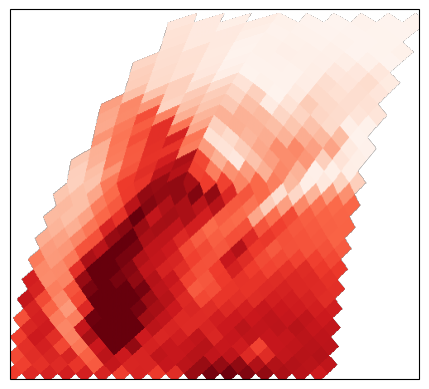

In [18]:
# This plots the entire world and then only shows a subset. So it's slower than sub-selecting the data first and then plotting

fig, ax = get_axis_la(north_america, subplot_kw={'projection': ccrs.Robinson()})
egh.healpix_show(get_quantile(na_cape,0.97), ax=ax, cmap='Reds', vmin=0, vmax=3000)
# ax.set_global()
# ax.scatter(-100, 45, transform=ccrs.PlateCarree())
# plt.show()

In [20]:
# This plots the entire world and then only shows a subset. So it's slower than sub-selecting the data first and then plotting

fig, ax = #get_axis_la(se_australia, subplot_kw={'projection': ccrs.PlateCarree()})
egh.healpix_show(get_quantile(au_cape,0.97), ax=ax, cmap='Reds', vmin=0, vmax=3000)
plt.show()

SyntaxError: invalid syntax (1385956738.py, line 3)